In [1]:
import pandas as pd
import numpy as np
from glob import glob
import keras
import os
import AngularGrid
import tensorflow as tf
import wandb

from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector, concatenate, Concatenate
from keras.layers.normalization.batch_normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline

2022-09-23 18:51:07.971256: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-23 18:51:08.193677: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-23 18:51:08.279697: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-23 18:51:08.985224: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
def readFile(file):
  train = pd.read_csv(file)
  return train

def buildTrainXY(train_x, train_y):
  X_train, Y_train = [], []
  X_train = [[train_x.iloc[0]['pos_x'], train_x.iloc[0]['pos_y'], train_x.iloc[0]['vel_x'], train_x.iloc[0]['vel_y']]]
  y_lst = []
  for i in range(len(train_y)):
    # y_lst.append([train_y.iloc[i]['pos_x'], train_y.iloc[i]['pos_y'], train_y.iloc[i]['vel_x'], train_y.iloc[i]['vel_y']])
    y_lst.append(train_y.iloc[i]['pos_x'])
    y_lst.append(train_y.iloc[i]['pos_y'])
    y_lst.append(train_y.iloc[i]['vel_x'])
    y_lst.append(train_y.iloc[i]['vel_y'])
  Y_train.append([y_lst])
  
  Y_train = list(np.array(Y_train).flat)
  return X_train, Y_train

def buildTrainAG(train_ag):
  AG_train = [train_ag.iloc[0]]
  return AG_train

def get_ADE_FDE(pred, test, pred_time):
  ade, fde = 0, 0

  for i in range(len(pred)):
    individual_ade, individual_fde = 0, 0
    pred_info = pred.iloc[i]
    test_info = test.iloc[i]
    t = 0
  
    for p in range(0, pred.shape[1],4):
      t += 1
      pred_pos = AngularGrid.pt(pred_info[p], pred_info[p+1])
      test_pos = AngularGrid.pt(test_info[p], test_info[p+1])
      dist = AngularGrid.pt.distance(pred_pos, test_pos)
      individual_ade += dist
      if t == pred_time:
        individual_fde += dist
      else:
        pass
    individual_ade = individual_ade / pred_time
    # print('ade = ', individual_ade,'\nfde = ', individual_fde)
    ade += individual_ade
    fde += individual_fde
  ade = ade / len(pred)
  fde = fde / len(pred)
  return np.round(ade, 6), np.round(fde, 6)

In [ ]:
wandb.init(project="MotionPrediction")

In [3]:
folder = "/home/linsea/motion_ws/src/motion_prediction/data/ETH/"
i, testing_num = 1, 380
X_train ,Y_train , AG_train= [], [], []
X_test ,Y_test , AG_test= [], [], []
index = 0

for file in glob(os.path.join(folder+'train_x/',"*.csv")):
  index +=1
  if index % 1000 == 0:
    print(index)
  file_name = file.split('/')[-1]
  train_x = readFile(file)
  train_y = readFile(folder + 'train_y/' + file_name)
  train_ag = readFile(folder + 'train_ag/' + file_name)
  X, Y = buildTrainXY(train_x, train_y)
  AG = buildTrainAG(train_ag)
  if i > testing_num:
    X_train.append(X)       #ped_state
    Y_train.append(Y)       #ped_pred
    AG_train.append(AG)     #ag
  else:
    X_test.append(X)
    Y_test.append(Y)
    AG_test.append(AG)
  i+=1

X_train = np.array(X_train)
Y_train = np.array(Y_train)
AG_train = np.array(AG_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)
AG_test = np.array(AG_test)


In [4]:
print('ped state shape:\t',X_train.shape)
print('ag shape:\t\t',AG_train.shape)
print('ped pred shape:\t\t',Y_train.shape)
print('\nped state test shape:\t',X_test.shape)
print('ag test shape:\t\t',AG_test.shape)
print('ped pred test shape:\t',Y_test.shape)

ped state shape:	 (6742, 1, 4)
ag shape:		 (6742, 1, 72)
ped pred shape:		 (6742, 20)

ped state test shape:	 (380, 1, 4)
ag test shape:		 (380, 1, 72)
ped pred test shape:	 (380, 20)


settings

In [5]:
epochs = 50
lr = 0.001
batch_size = 16

In [6]:
cfg = wandb.config
cfg.architecture = 'ped state + surrounding'
cfg.dataset = 'ETH'
cfg.epochs = epochs
cfg.learning_rate = lr
cfg.batch_size = batch_size
cfg.ped_input_shape = X_train.shape
cfg.AG_input_shape = AG_train.shape
cfg.output_shape = Y_train.shape

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Currently logged in as: linsea. Use `wandb login --relogin` to force relogin


In [7]:
ped_input = keras.Input(shape=( 1, 4), name= 'ped')
ped_features = LSTM(32)(ped_input)

ag_input = keras.Input(shape=( 1, 72), name= 'ag')
ag_features = Dense(128)(ag_input)
ag_features = LSTM(128)(ag_features)

x = concatenate([ ped_features, ag_features], axis=-1)
x = tf.expand_dims(x,axis=1)
x = LSTM(160)(x)

x = Dense(256, activation="relu")(x)
x = Dense(128, activation="linear")(x)

ped_pred = Dense(20, name='ped_pred')(x)

model = keras.Model(inputs = [ped_input, ag_input],
                    outputs = [ped_pred],
)
model.compile(
    optimizer = Adam(lr),
    loss=keras.losses.MeanSquaredError(),
)
model.summary()

2022-09-23 18:51:53.223355: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-23 18:51:53.254315: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-23 18:51:53.254737: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-23 18:51:53.256181: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ag (InputLayer)                [(None, 1, 72)]      0           []                               
                                                                                                  
 ped (InputLayer)               [(None, 1, 4)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 1, 128)       9344        ['ag[0][0]']                     
                                                                                                  
 lstm (LSTM)                    (None, 32)           4736        ['ped[0][0]']                    
                                                                                              

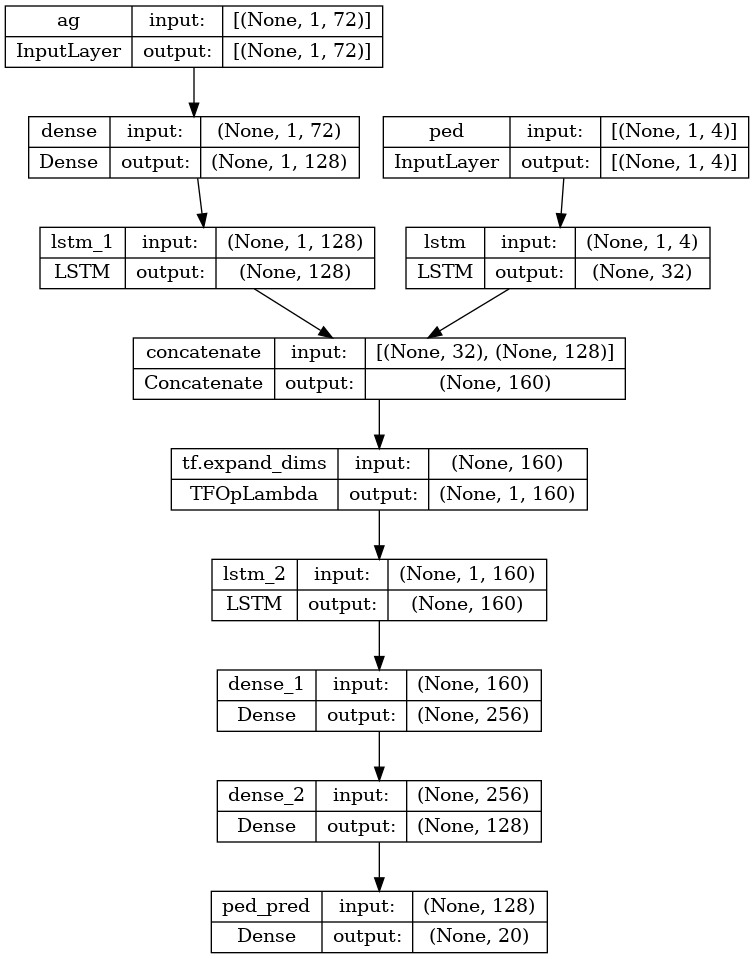

In [8]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [9]:
ped_data = X_train
ag_data = AG_train
ped_pred_data = Y_train


model.fit(
  {'ped': ped_data,'ag': ag_data},
  {'ped_pred': ped_pred_data},
  epochs = 50,
  batch_size = 16,
  validation_split=0.2,
)


Epoch 1/50


2022-09-23 18:52:03.638043: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-09-23 18:52:04.483966: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204


338/338 [==============================] - 6s 5ms/step - loss: 2.0829 - val_loss: 0.0826
Epoch 2/50
338/338 [==============================] - 1s 3ms/step - loss: 0.0669 - val_loss: 0.0688
Epoch 3/50
338/338 [==============================] - 1s 3ms/step - loss: 0.0613 - val_loss: 0.0668
Epoch 4/50
338/338 [==============================] - 1s 3ms/step - loss: 0.0581 - val_loss: 0.0639
Epoch 5/50
338/338 [==============================] - 1s 3ms/step - loss: 0.0563 - val_loss: 0.0854
Epoch 6/50
338/338 [==============================] - 1s 4ms/step - loss: 0.0534 - val_loss: 0.0509
Epoch 7/50
338/338 [==============================] - 1s 4ms/step - loss: 0.0503 - val_loss: 0.0478
Epoch 8/50
338/338 [==============================] - 1s 3ms/step - loss: 0.0490 - val_loss: 0.0563
Epoch 9/50
338/338 [==============================] - 1s 4ms/step - loss: 0.0478 - val_loss: 0.0412
Epoch 10/50
338/338 [==============================] - 1s 3ms/step - loss: 0.0484 - val_loss: 0.0519
Epoch 11/5

In [10]:
preds = model.predict([X_test, AG_test])
loss_metrics = model.evaluate([X_test, AG_test], Y_test)

12/12 [==============================] - 1s 2ms/step - loss: 0.0427


In [11]:
preds = pd.DataFrame(preds)
Y_test = pd.DataFrame(Y_test)

In [12]:
ade, fde = get_ADE_FDE(preds, Y_test, 5)
print('ade = ', ade,'\nfde = ', fde)

wandb.config.ade = ade
wandb.config.fde = fde
image = wandb.Image(array_or_path, caption="Input image")
wandb.finish()
      


ade =  0.233784 
fde =  0.340998


In [16]:
# num_tags = 12  # Number of unique issue tags
# num_words = 10000  # Size of vocabulary obtained when preprocessing text data
# num_departments = 4  # Number of departments for predictions

# title_input = keras.Input(
#     shape=(None,), name="title"
# )
# body_input = keras.Input(shape=(None,), name="body")
# tags_input = keras.Input(
#     shape=(num_tags,), name="tags"
#  )

# title_features = keras.layers.Embedding(num_words, 64)(title_input)
# body_features = keras.layers.Embedding(num_words, 64)(body_input)

# title_features = LSTM(128)(title_features)
# body_features = LSTM(32)(body_features)

# x = keras.layers.concatenate([title_features, body_features, tags_input])

# priority_pred = Dense(1, name="priority")(x)
# department_pred = Dense(num_departments, name="department")(x)

# model = keras.Model(
#     inputs=[title_input, body_input, tags_input],
#     outputs=[priority_pred, department_pred],
# )
